## Compare CatBoost in the case of binary class (Sell, Buy)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path

# in jupyter (lab / notebook), based on notebook path
module_path = str(Path.cwd().parents[0] / "src")


if module_path not in sys.path:
    sys.path.append(module_path)
import optuna
import pandas as pd
from catboost import CatBoostClassifier
from sklearn.impute import SimpleImputer

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from utility_functions import (
    plot_feature_imp,
    plot_strategy,
    backtest_strategy,
    display_report,
    objective_catboost,
)

In [ ]:
metric = "recall_macro"

In [2]:
spy = pd.read_csv("../data/raw/spy.csv", parse_dates=True, index_col=0)

In [3]:
target = pd.read_csv("../data/processed/target_df.csv", parse_dates=True, index_col=0)[
    "target"
]

In [4]:
ml_df = pd.read_csv("../data/processed/ml_df.csv", parse_dates=True, index_col=0)

In [5]:
wk_df = pd.read_csv("../data/processed/exp_price.csv", parse_dates=True, index_col=0)

In [6]:
interest_rate = wk_df["r"].values

## Baseline CatBoost Classifier without new data + r

In [7]:
orig_df = ml_df[
    [
        "UNDERLYING_LAST",
        "STRIKE",
        "C_LAST",
        "C_BID",
        "C_ASK",
        "C_IV",
        "C_VOLUME",
        "diff_date",
    ]
].copy()

In [8]:
orig_df["r"] = interest_rate

### In sample predictions

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df, target.values.flatten(), test_size=199, random_state=1968, shuffle=True
)

### Hyper-parameters tuning using Optuna

In [10]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_catboost(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=600,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-12 21:32:59,516] A new study created in memory with name: no-name-e1508281-1821-4a16-b591-f38a28fbb6cb
[I 2024-02-12 21:33:01,869] Trial 0 finished with value: 0.5171312385591741 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.03189267346182267, 'learning_rate': 0.02125010865166753, 'depth': 6, 'boosting_type': 'Plain', 'l2_leaf_reg': 10, 'min_data_in_leaf': 40, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3596859987409826}. Best is trial 0 with value: 0.5171312385591741.
[I 2024-02-12 21:33:03,709] Trial 1 finished with value: 0.21036769819979284 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.013964292899701206, 'learning_rate': 0.01101696546352072, 'depth': 2, 'boosting_type': 'Plain', 'l2_leaf_reg': 4, 'min_data_in_leaf': 36, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 1.3079409104055217}. Best is trial 0 with value: 0.5171312385591741.
[I 2024-02-12 21:33:10,217] Trial 2 finished with value: 0.4016645160117771

Number of finished trials: 150
Best trial:
  Value: 0.6685818248718772
  Params: 
    objective: CrossEntropy
    colsample_bylevel: 0.09482868159525029
    learning_rate: 0.07158207460202366
    depth: 7
    boosting_type: Plain
    l2_leaf_reg: 9
    min_data_in_leaf: 9
    bootstrap_type: Bernoulli
    subsample: 0.8543904047864175


In [11]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "rf",
            CatBoostClassifier(
                **study.best_params
                | {
                    "used_ram_limit": "3gb",
                    "eval_metric": "Accuracy",
                    "early_stopping_rounds": 50,
                    "random_state": 1968,
                    "silent": True,
                }
            ),
        ),
    ]
)

In [12]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x133944690>)])

In [13]:
predictions = pipe.predict(X_test)

In [14]:
pipe.score(X_test, y_test)

0.7437185929648241

              precision    recall  f1-score   support

           0       0.71      0.82      0.76       100
           1       0.79      0.67      0.72        99

    accuracy                           0.74       199
   macro avg       0.75      0.74      0.74       199
weighted avg       0.75      0.74      0.74       199



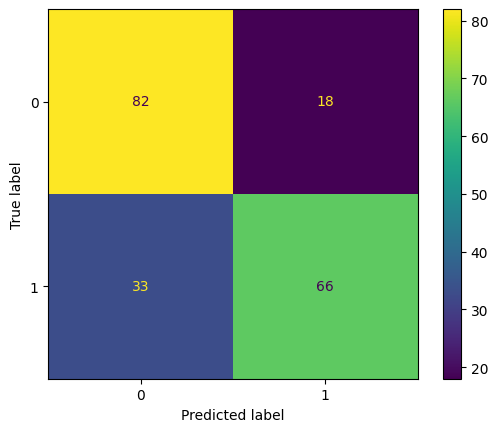

In [15]:
display_report(y_test, predictions)

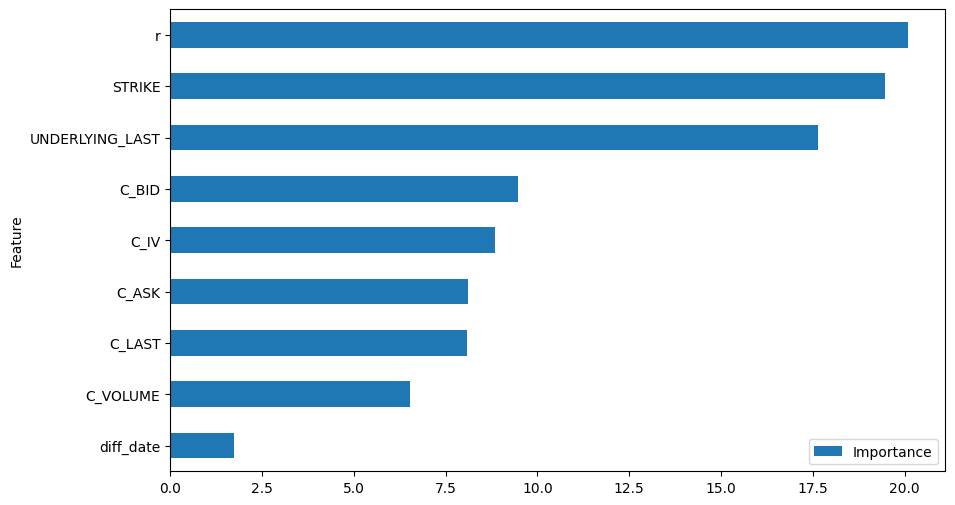

In [16]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [17]:
compare_df = pd.DataFrame(predictions, columns=["bare_rf_pred_in"])

### Backtesting

In [18]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [19]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-01-17,0,280.0,2.40,2018-02-07,267.670013,0.000000,-2.400000,0.000000,-2.400000
2018-02-09,0,262.0,5.77,2018-03-02,269.079987,0.000000,1.309987,0.000000,-1.090013
2018-02-22,0,270.0,4.26,2018-03-14,275.299988,0.000000,1.039988,0.000000,-0.050026
2018-02-28,1,271.0,4.86,2018-03-21,270.429993,-4.860000,-4.860000,-4.860000,-4.910026
2018-03-08,0,274.0,2.85,2018-03-29,263.149994,0.000000,-2.850000,-4.860000,-7.760026
...,...,...,...,...,...,...,...,...,...
2023-11-22,0,455.0,5.55,2023-12-15,469.329987,0.000000,8.779987,310.400155,286.530096
2023-11-27,1,455.0,4.55,2023-12-15,469.329987,9.779987,9.779987,320.180142,296.310083
2023-11-30,0,456.0,5.38,2023-12-22,473.649994,0.000000,12.269994,320.180142,308.580077


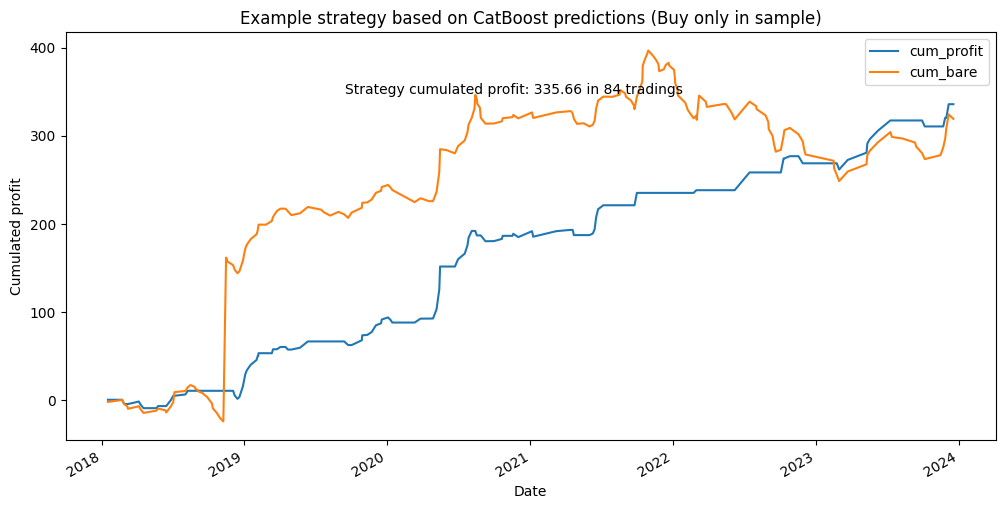

In [20]:
plot_strategy(strategy_df, "CatBoost", "(Buy only in sample)")

### Out-of-sample predictions

In [21]:
X_train, X_test, y_train, y_test = train_test_split(
    orig_df,
    target.values.flatten(),
    test_size=199,
    random_state=1968,
    shuffle=False,
)

In [22]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "rf",
            CatBoostClassifier(
                **study.best_params
                | {
                    "used_ram_limit": "3gb",
                    "eval_metric": "Accuracy",
                    "early_stopping_rounds": 50,
                    "random_state": 1968,
                    "silent": True,
                }
            ),
        ),
    ]
)

In [23]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x133be8350>)])

In [24]:
predictions = pipe.predict(X_test)

In [25]:
pipe.score(X_test, y_test)

0.5125628140703518

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        98
           1       1.00      0.04      0.08       101

    accuracy                           0.51       199
   macro avg       0.75      0.52      0.37       199
weighted avg       0.76      0.51      0.37       199



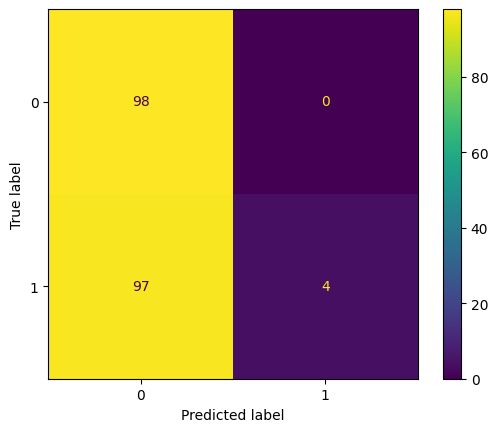

In [26]:
display_report(y_test, predictions)

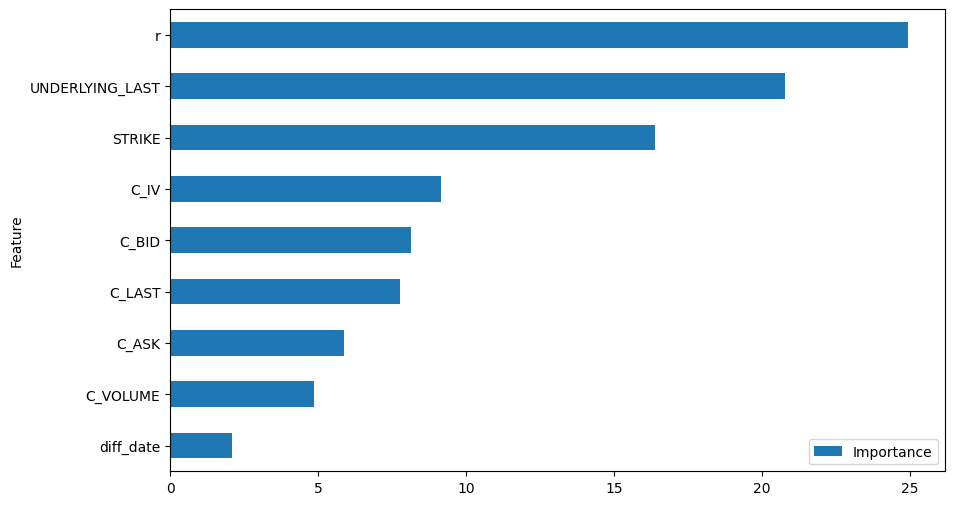

In [27]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = orig_df.columns
plot_feature_imp(coefficients, columns)

In [28]:
compare_df["bare_rf_pred_out"] = predictions

### Backtesting

In [29]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [30]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,0,388.0,7.72,2023-01-27,405.679993,0.000000,9.959993,32.399985,42.359978
2023-01-09,0,388.0,7.46,2023-01-27,405.679993,0.000000,10.219993,32.399985,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,32.399985,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,63.240015,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,63.240015,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,63.240015,401.389886


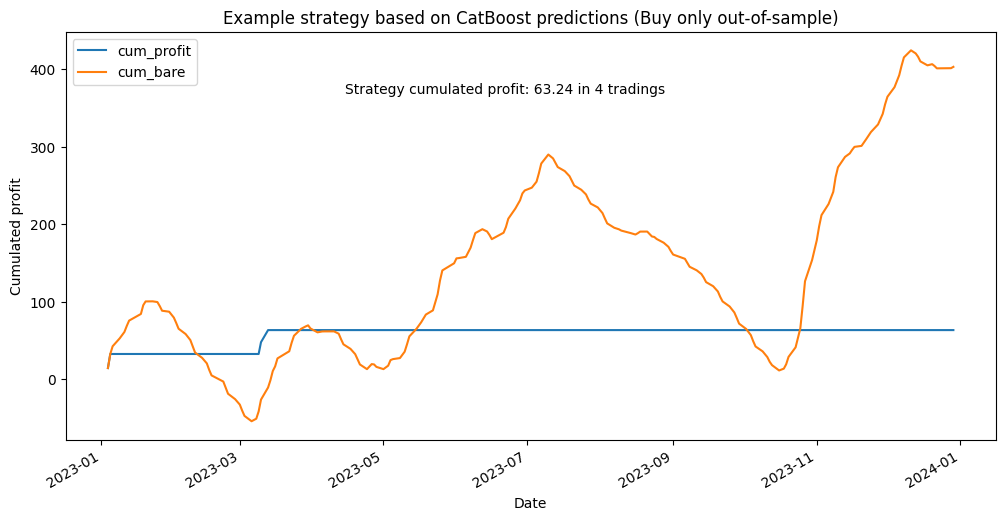

In [31]:
plot_strategy(strategy_df, "CatBoost", "(Buy only out-of-sample)")

## CatBoost with data from MC simulation and additional features

In [32]:
new_df = pd.concat(
    (
        ml_df[
            [
                "UNDERLYING_LAST",
                "STRIKE",
                "C_LAST",
                "C_BID",
                "C_ASK",
                "C_IV",
                "C_VOLUME",
                "diff",
            ]
        ],
        wk_df.drop(["last_quote", "strike"], axis=1),
    ),
    axis=1,
)

In [33]:
# Add some features
new_df["iqr"] = new_df["exp_price_q3"] - new_df["exp_price_q1"]
new_df["diff_call"] = new_df["exp_call_price"] - new_df["C_LAST"]
new_df["exp_price_var"] = np.power(new_df["exp_price_std"], 2)
new_df["exp_profit"] = new_df["exp_price"] - (new_df["STRIKE"] + new_df["C_LAST"])

### In-sample predictions

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df, target.values.flatten(), test_size=199, random_state=1968, shuffle=True
)

### Hyper-parameters tuning using Optuna

In [35]:
study = optuna.create_study(direction="maximize")
study.optimize(
    lambda trial: objective_catboost(trial, X_train, y_train, metric),
    n_trials=150,
    timeout=1200,
)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

[I 2024-02-12 21:41:00,569] A new study created in memory with name: no-name-a15c33cd-0605-47f6-adf3-0c4db386c047
[I 2024-02-12 21:41:10,678] Trial 0 finished with value: 0.6485079265793469 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.07733984964552608, 'learning_rate': 0.0051880377901640335, 'depth': 11, 'boosting_type': 'Plain', 'l2_leaf_reg': 5, 'min_data_in_leaf': 67, 'bootstrap_type': 'Bayesian', 'bagging_temperature': 6.844158063269033}. Best is trial 0 with value: 0.6485079265793469.
[I 2024-02-12 21:41:12,775] Trial 1 finished with value: 0.6423738814076918 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.035391759578581275, 'learning_rate': 0.015081998157528238, 'depth': 4, 'boosting_type': 'Plain', 'l2_leaf_reg': 4, 'min_data_in_leaf': 33, 'bootstrap_type': 'Bernoulli', 'subsample': 0.49276654627021294}. Best is trial 0 with value: 0.6485079265793469.
[I 2024-02-12 21:41:19,454] Trial 2 finished with value: 0.5735013819390752 and paramet

Number of finished trials: 102
Best trial:
  Value: 0.7398016266363454
  Params: 
    objective: Logloss
    colsample_bylevel: 0.07553009041523888
    learning_rate: 0.05388000373873721
    depth: 7
    boosting_type: Ordered
    l2_leaf_reg: 5
    min_data_in_leaf: 86
    bootstrap_type: MVS


In [36]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "rf",
            CatBoostClassifier(
                **study.best_params
                | {
                    "used_ram_limit": "3gb",
                    "eval_metric": "Accuracy",
                    "early_stopping_rounds": 50,
                    "random_state": 1968,
                    "silent": True,
                }
            ),
        ),
    ]
)

In [37]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x133c39650>)])

In [38]:
predictions = pipe.predict(X_test)

In [39]:
pipe.score(X_test, y_test)

0.7638190954773869

              precision    recall  f1-score   support

           0       0.74      0.82      0.78       100
           1       0.80      0.71      0.75        99

    accuracy                           0.76       199
   macro avg       0.77      0.76      0.76       199
weighted avg       0.77      0.76      0.76       199



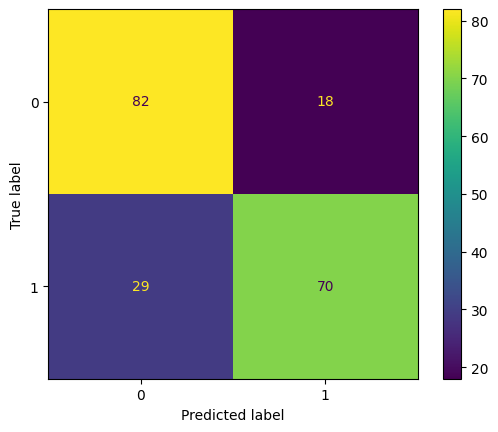

In [40]:
display_report(y_test, predictions)

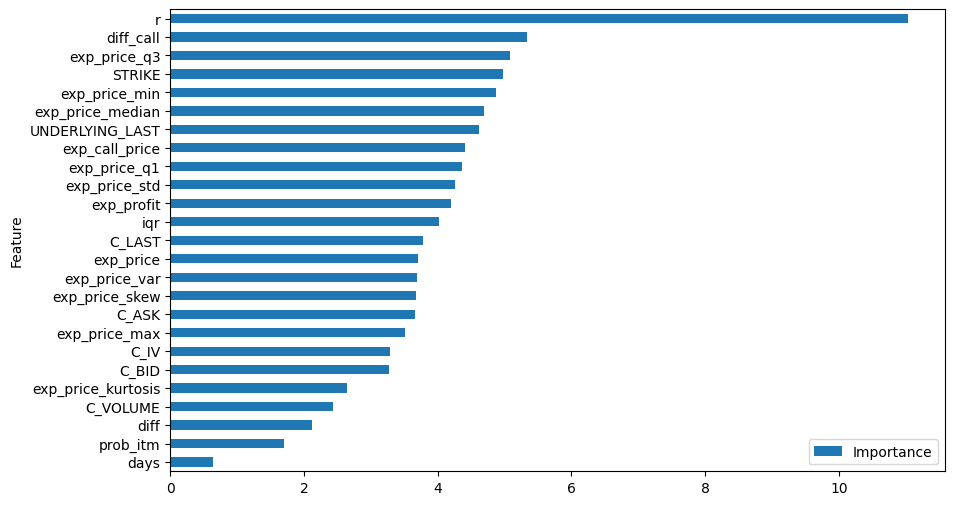

In [41]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [42]:
compare_df["mmar_rf_pred_in"] = predictions

### Backtesting

In [43]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [44]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2018-01-17,1,280.0,2.40,2018-02-07,267.670013,-2.400000,-2.400000,-2.400000,-2.400000
2018-02-09,1,262.0,5.77,2018-03-02,269.079987,1.309987,1.309987,-1.090013,-1.090013
2018-02-22,0,270.0,4.26,2018-03-14,275.299988,0.000000,1.039988,-1.090013,-0.050026
2018-02-28,1,271.0,4.86,2018-03-21,270.429993,-4.860000,-4.860000,-5.950013,-4.910026
2018-03-08,0,274.0,2.85,2018-03-29,263.149994,0.000000,-2.850000,-5.950013,-7.760026
...,...,...,...,...,...,...,...,...,...
2023-11-22,1,455.0,5.55,2023-12-15,469.329987,8.779987,8.779987,375.330134,286.530096
2023-11-27,0,455.0,4.55,2023-12-15,469.329987,0.000000,9.779987,375.330134,296.310083
2023-11-30,0,456.0,5.38,2023-12-22,473.649994,0.000000,12.269994,375.330134,308.580077


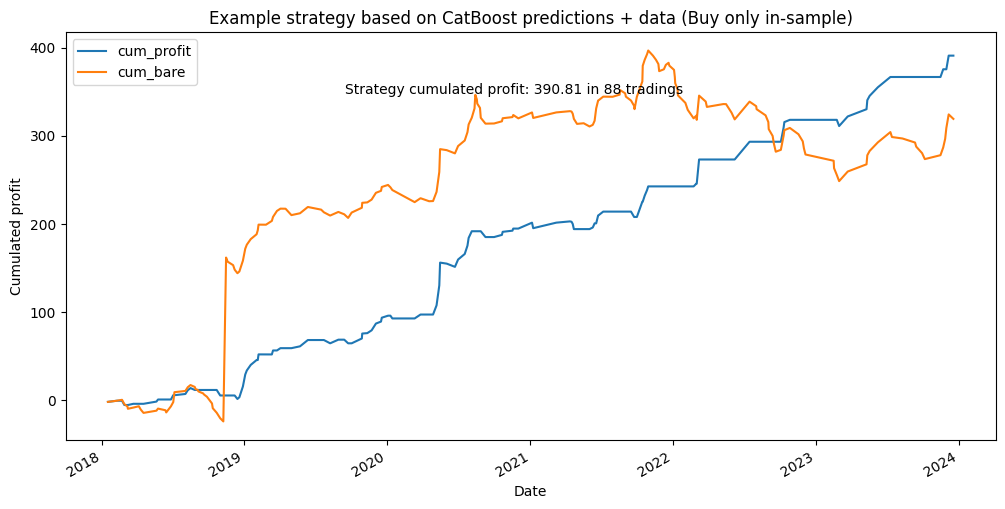

In [45]:
plot_strategy(strategy_df, "CatBoost", "+ data (Buy only in-sample)")

### Out-of-sample predictions

In [46]:
X_train, X_test, y_train, y_test = train_test_split(
    new_df,
    target.values.flatten(),
    test_size=199,
    random_state=1968,
    shuffle=False,
)

In [47]:
pipe = Pipeline(
    [
        ("imputer", SimpleImputer(strategy="constant", fill_value=0.0)),
        (
            "rf",
            CatBoostClassifier(
                **study.best_params
                | {
                    "used_ram_limit": "3gb",
                    "eval_metric": "Accuracy",
                    "early_stopping_rounds": 50,
                    "random_state": 1968,
                    "silent": True,
                }
            ),
        ),
    ]
)

In [48]:
# Fit the tuned model
pipe.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer(fill_value=0.0, strategy='constant')),
                ('rf',
                 <catboost.core.CatBoostClassifier object at 0x133d0f7d0>)])

In [49]:
predictions = pipe.predict(X_test)

In [50]:
pipe.score(X_test, y_test)

0.5125628140703518

              precision    recall  f1-score   support

           0       0.50      1.00      0.67        98
           1       1.00      0.04      0.08       101

    accuracy                           0.51       199
   macro avg       0.75      0.52      0.37       199
weighted avg       0.76      0.51      0.37       199



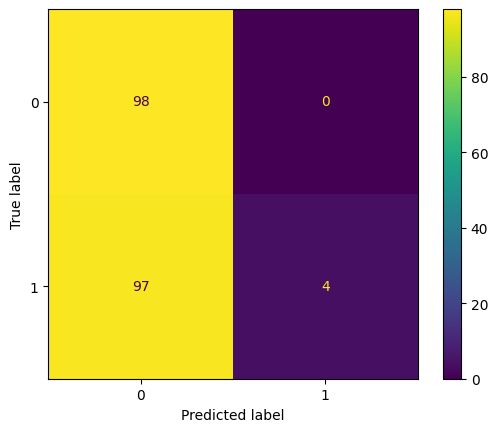

In [51]:
display_report(y_test, predictions)

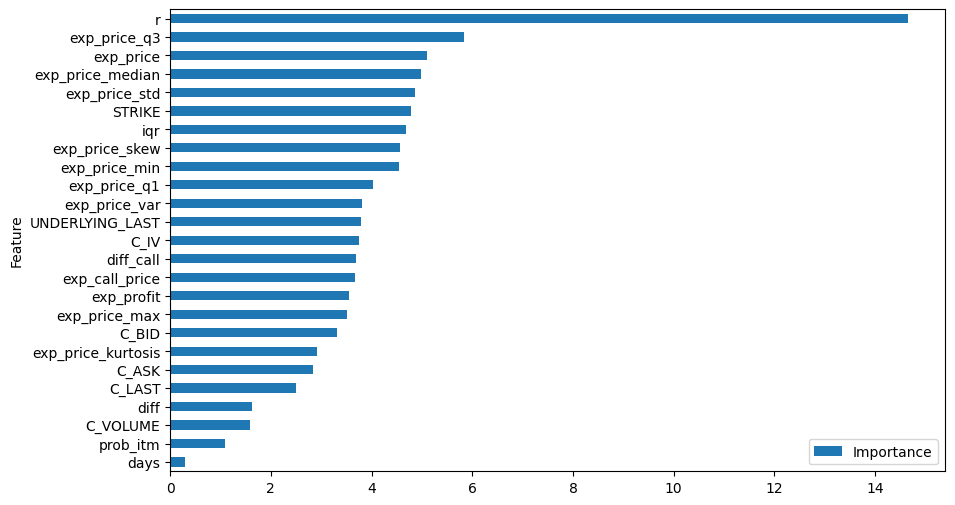

In [52]:
coefficients = pipe.named_steps["rf"].feature_importances_
columns = new_df.columns
plot_feature_imp(coefficients, columns)

In [53]:
compare_df["mmar_rf_pred_out"] = predictions

### Backtesting

In [54]:
strategy_df = backtest_strategy(predictions, X_test, spy, ml_df)

In [55]:
strategy_df

,strategy,strike,call_price,exp_date,final_price,profit,bare,cum_profit,cum_bare
Date,,,,,,,,,
2023-01-04,1,384.0,7.46,2023-01-27,405.679993,14.219993,14.219993,14.219993,14.219993
2023-01-05,1,379.0,8.50,2023-01-27,405.679993,18.179993,18.179993,32.399985,32.399985
2023-01-06,0,388.0,7.72,2023-01-27,405.679993,0.000000,9.959993,32.399985,42.359978
2023-01-09,0,388.0,7.46,2023-01-27,405.679993,0.000000,10.219993,32.399985,52.579971
2023-01-11,0,395.0,9.11,2023-02-03,412.350006,0.000000,8.240006,32.399985,60.819977
...,...,...,...,...,...,...,...,...,...
2023-12-21,0,473.0,6.07,2024-01-12,476.679993,0.000000,-2.390007,63.240015,404.169901
2023-12-22,0,474.0,5.70,2024-01-12,476.679993,0.000000,-3.020007,63.240015,401.149894
2023-12-27,0,476.0,6.19,2024-01-19,482.429993,0.000000,0.239993,63.240015,401.389886


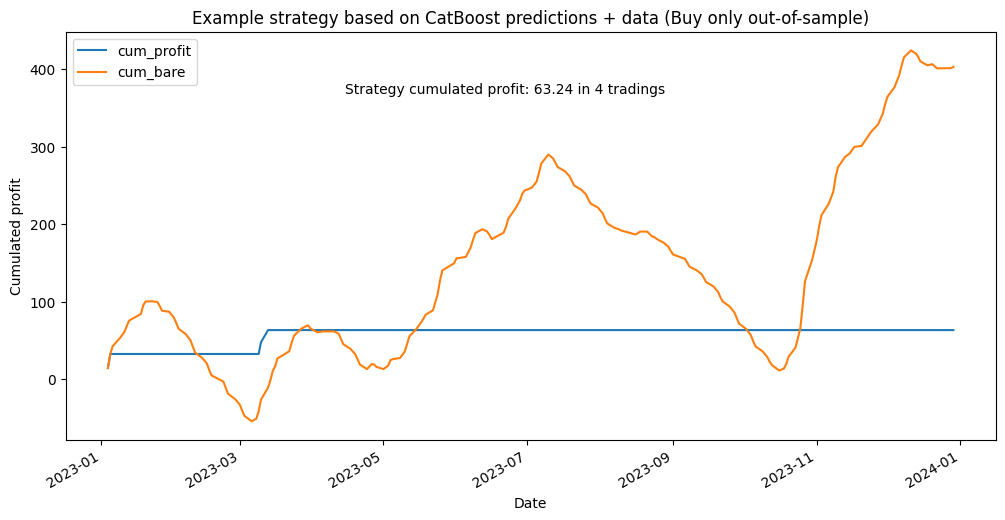

In [56]:
plot_strategy(strategy_df, "CatBoost", "+ data (Buy only out-of-sample)")

## Compare the two predictions

In [57]:
mask_in = (compare_df["bare_rf_pred_in"] - compare_df["mmar_rf_pred_in"]).astype(bool)
mask_out = (compare_df["bare_rf_pred_out"] - compare_df["mmar_rf_pred_out"]).astype(
    bool
)

In [58]:
compare_df[mask_in]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out
0,0,1,1,1
10,1,0,0,0
15,1,0,0,0
23,0,0,1,0
26,0,0,1,0
30,0,0,1,0
31,1,0,0,0
40,0,0,1,0
46,0,0,1,0
49,0,0,1,0


In [59]:
compare_df[mask_in].shape

(40, 4)

In [60]:
# Compare out of sample preds
compare_df[mask_out]

,bare_rf_pred_in,bare_rf_pred_out,mmar_rf_pred_in,mmar_rf_pred_out


In [61]:
compare_df[mask_out].shape

(0, 4)

In [62]:
compare_df.sum(axis=0)

bare_rf_pred_in     84
bare_rf_pred_out     4
mmar_rf_pred_in     88
mmar_rf_pred_out     4
dtype: int64